# Coordinate transformations and Error Propagation

The idea is to explore different options to propagate errors from observables ($\alpha$, $\delta$, $\varpi$, $\mu_{\alpha*}$, $\mu_\delta$ and $V_r$) to Cartesian Heliocentric Velocity. In between, we shall see also transformations to intermediate coordinate systems (basically Galactic spherical coordinates).

We shall see three ways:
- Astropy
- PyGaia
- GalPy _(soon)_
- Python Code  

__(¡¡WATCH OUT!! Parallax error -> the Jacobian is asuming that distance = 1/plx)__

For each one, we will average a thousand executions using _timeit_ package and obtain an estimated time cost.

In [3]:
import timeit
import numpy as np

In [4]:
""" Test star coordinates & errors """
    #J2000
ra=266.40506655 #right ascention in degrees
dec=-28.93616241 #declination in degrees
plx=4 #parallax in mas
pmra=2 #proper motion in alpha* in mas/yr
pmdec=3 #proper motion in delta in mas/yr
vr=0 #radial velocity in km/s

e_ra=0.1 #error in RA in mas
e_dec=0.1 #error in DEC in mas
e_plx=0.3 #error in plx in mas
e_pmra=0.7 #error in PMRA in mas/yr
e_pmdec=0.7 #error in PMDEC in mas/yr
e_vr=0 #error in Vr in km/s

c_plx_pmra = 0.5 #correlation parallax pmra
c_plx_pmdec= 0.5 #correlation parallax pmdec
c_pmra_pmdec=0.5 #correlation pmra pmdec


""" Correct values based on NED calculator (ned.ipac.caltech.edu)
l=0 degrees
b=0 degrees
d=250 pc (1/plx)
 """

' Correct values based on NED calculator (ned.ipac.caltech.edu)\nl=0 degrees\nb=0 degrees\nd=250 pc (1/plx)\n '

## 1) Astropy


In [5]:
from astropy import units as u
from astropy.coordinates import SkyCoord,Galactocentric
from astropy.coordinates import HeliocentricTrueEcliptic,Galactic,LSR,HCRS,ICRS

In [6]:
import astropy
astropy.version.version

'3.2.3'

In [7]:
star=SkyCoord(ra=ra*u.degree, dec=dec*u.degree,
                distance=(plx*u.mas).to(u.pc, u.parallax()),
                pm_ra_cosdec=pmra*u.mas/u.yr,
                pm_dec=pmdec*u.mas/u.yr,
                radial_velocity=vr*u.km/u.s)

In [8]:
star

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    (266.40506655, -28.93616241, 250.)
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    (2., 3., 0.)>

In [9]:
""" Part I: change of coordinates """
#A: ICRS to Galactic
star_GAL=star.transform_to(Galactic)
tAstro=timeit.timeit(stmt='star.transform_to(Galactic)',globals=globals(),number=1000)/1000

In [10]:
print('Astropy\n\tStar at ({} deg:{} deg) in ICRS ->\
({}:{}) in Gal.Coord.\n\nTime: {} seconds'.format(ra,dec,star_GAL.l,star_GAL.b,tAstro))

Astropy
	Star at (266.40506655 deg:-28.93616241 deg) in ICRS ->(4.879020186417789e-05 deg:-5.046269002433875e-05 deg) in Gal.Coord.

Time: 0.0074888002120424065 seconds


In [11]:
#B: ICRS to Galactocentric (http://docs.astropy.org/en/stable/generated/examples/coordinates/plot_galactocentric-frame.html)
star_cart = star.transform_to(Galactocentric)
tAstro=timeit.timeit(stmt='star.transform_to(Galactocentric)',globals=globals(),number=1000)/1000

In [12]:
print(star_cart.x,star_cart.y,star_cart.z)
print(star_cart.v_x,star_cart.v_y,star_cart.v_z)
print('Time: {}'.format(tAstro))

-8049.957406537863 pc -1.9663881033693542e-05 pc 26.186884633991347 pc
11.09944533596824 km / s 236.50959376672404 km / s 7.0793609528452714 km / s
Time: 0.007969647183897905


In [13]:
""" Part II: error propagation """
#As far as I know, not available -in a suitable way- in version 2.02 

' Part II: error propagation '

## 2) PyGaia


In [14]:
import pygaia.astrometry.vectorastrometry as vecast
from pygaia.astrometry.coordinates import CoordinateTransformation
from pygaia.astrometry.coordinates import Transformations

In [15]:
""" Part I: change of coordinates """

#A: ICRS to GAL
    #define the transformation
ICRS2GAL=CoordinateTransformation(Transformations.ICRS2GAL)

    #use the methods to transform: first the position
l,b=ICRS2GAL.transformSkyCoordinates(np.deg2rad(ra),np.deg2rad(dec))
tGaiaCoord=timeit.timeit(stmt='ICRS2GAL.transformSkyCoordinates(np.deg2rad(ra),np.deg2rad(dec))',
                    globals=globals(),number=1000)/1000

    #then the proper motions
mul,mub=ICRS2GAL.transformProperMotions(np.deg2rad(ra),np.deg2rad(dec),pmra,pmdec)
tGaiaPM=timeit.timeit(stmt='ICRS2GAL.transformProperMotions(np.deg2rad(ra),np.deg2rad(dec),pmra,pmdec)',
                    globals=globals(),number=1000)/1000

In [16]:
print('PyGaia\n\tStar at ({} deg:{} deg) in ICRS -> ({} deg:{} deg) in Gal.Coord.\n\nTime: {} seconds'.format(
    ra,dec,np.rad2deg(l),np.rad2deg(b),tGaiaCoord))

PyGaia
	Star at (266.40506655 deg:-28.93616241 deg) in ICRS -> (4.257483637742752e-05 deg:-4.7577247564556497e-05 deg) in Gal.Coord.

Time: 5.498246708884835e-05 seconds


In [17]:
print('PyGaia\n\tStar at ({} mas/yr:{} mas/yr) in ICRS -> ({} mas/yr:{} mas/yr) in Gal.Coord.\n\nTime: {} seconds'.format(
    pmra,pmdec,mul,mub,tGaiaPM))

PyGaia
	Star at (2 mas/yr:3 mas/yr) in ICRS -> (3.6026749209392523 mas/yr:-0.1439910206761177 mas/yr) in Gal.Coord.

Time: 7.710632099770009e-05 seconds


In [21]:
#B: GAL to Helio-cartesian
    #to change to cartesian, we use the module 'vecast'
x,y,z,U,V,W=vecast.astrometryToPhaseSpace(l,b,plx,mul,mub,vr)
tGaia=timeit.timeit(stmt='vecast.astrometryToPhaseSpace(l,b,plx,mul,mub,vr)',
                    globals=globals(),number=1000)/1000

In [22]:
print('PyGaia\n\tStar at ({} deg:{} deg:{} mas) in GAL -> ({} pc:{} pc:{} pc) in Heliocentric.Coord.\n\nTime:\
{} seconds'.format(
    np.rad2deg(l),np.rad2deg(b),plx,x,y,z,tGaia))

PyGaia
	Star at (4.257483637742752e-05 deg:-4.7577247564556497e-05 deg:4 mas) in GAL -> (249.9999999998448 pc:0.00018576776832091022 pc:-0.0002075949047594672 pc) in Heliocentric.Coord.

Time:6.042544199954136e-05 seconds


In [7]:
#A+B:ICRS to Heliocentric Cartesian
    #full transformation in one function
def pygaiachange(ra,dec,plx,pmra,pmdec,vr):
    """ From observables in ICRS (angles in degrees, plx in mas, proper motion in mas/yr, los velocity in km/s)
    returns X,Y,Z (in pc) and U,V,W (in km/s)."""
    import pygaia.astrometry.vectorastrometry as vecast
    from pygaia.astrometry.coordinates import CoordinateTransformation
    from pygaia.astrometry.coordinates import Transformations   
    ICRS2GAL=CoordinateTransformation(Transformations.ICRS2GAL)
    #GAL2ICRS=CoordinateTransformation(Transformations.GAL2ICRS)

    l,b=ICRS2GAL.transformSkyCoordinates(np.deg2rad(ra),np.deg2rad(dec))
    mul,mub=ICRS2GAL.transformProperMotions(np.deg2rad(ra),np.deg2rad(dec),pmra,pmdec)
    
    return vecast.astrometryToPhaseSpace(l,b,plx,mul,mub,vr)

x,y,z,U,V,W=pygaiachange(ra,dec,plx,pmra,pmdec,vr)
tGaia=timeit.timeit(stmt='pygaiachange(ra,dec,plx,pmra,pmdec,vr)',
                    globals=globals(),number=1000)/1000

In [8]:
print('PyGaia\n\tStar at ({} deg:{} deg:{} mas) in ICRS -> ({} pc:{} pc:{} pc) in Heliocentric.Coord.\n\nTime:\
{} seconds'.format(
    ra,dec,plx,x,y,z,tGaia))

PyGaia
	Star at (266.40506655 deg:-28.93616241 deg:4 mas) in ICRS -> (249.9999999998448 pc:0.00018576776832091022 pc:-0.0002075949047594672 pc) in Heliocentric.Coord.

Time:0.0001886565249878913 seconds


In [25]:
print('PyGaia\n\tStar at ({} mas/yr:{} mas/yr:{} km/s) in ICRS -> ({} kms/s:{} km/s:{} km/s) in Heliocentric.Coord.\n\nTime:\
{} seconds'.format(
    pmra,pmdec,vr,U,V,W,tGaia))

PyGaia
	Star at (2 mas/yr:3 mas/yr:0 km/s) in ICRS -> (-3.3143126398119365e-06 kms/s:4.269593513104933 km/s:-0.1706462951322301 km/s) in Heliocentric.Coord.

Time:0.00023921741099911743 seconds


In [ ]:
""" Part II: error propagation (only rotations)"""

"""
Version 1.2 (December 2016)
++++++++++++++++++++
- Add method to CoordinateTransformation for the transformation of the full (5x5) covariance matrix of
  the astrometric parameters.

- Add keyword to astrometric errors prediction functions that allows to specify an extended mission
  lifetime.
  
  
+  def transformCovarianceMatrix(self, phi, theta, covmat):
+      
+      Transform the astrometric covariance matrix to its representation in the new coordinate system.
+
+      Parameters
+      ----------
+
+      phi       - The longitude-like angle of the position of the source (radians).
+      theta     - The latitude-like angle of the position of the source (radians).
+      covmat    - Covariance matrix (5x5) of the astrometric parameters.
+
+      Returns
+      -------
+
+      covmat_rot - Covariance matrix in its representation in the new coordinate system.
+      
+
+      c, s = self._getJacobian(phi,theta)
+      jacobian = identity(5)
+      jacobian[0][0]=c
+      jacobian[1][1]=c
+      jacobian[3][3]=c
+      jacobian[4][4]=c
+      jacobian[0][1]=s
+      jacobian[1][0]=-s
+      jacobian[3][4]=s
+      jacobian[4][3]=-s
+
+      return dot( dot(jacobian, covmat), jacobian.transpose() )
+
   def _getJacobian(self, phi, theta):
     
     Calculates the Jacobian for the transformation of the position errors and proper motion errors
     between coordinate systems. This Jacobian is also the rotation matrix for the transformation of
     proper motions. See section 1.5.3 of the Hipparcos Explanatory Volume 1 (equation 1.5.20).
 
     Parameters
     ----------
 
     phi       - The longitude-like angle of the position of the source (radians).
     theta     - The latitude-like angle of the position of the source (radians).
 
     Returns
     -------
 
     jacobian - The Jacobian matrix corresponding to (phi, theta) and the currently desired coordinate
                system transformation.
     
 
     p, q, r = normalTriad(phi, theta)
 
     # zRot = z-axis of new coordinate system expressed in terms of old system
     zRot = self.rotationMatrix[2,:]
     zRotAll = zRot
     if (p.ndim == 2):
       for i in range(p.shape[1]-1):
         zRotAll = vstack((zRotAll,zRot))
     pRot = cross(zRotAll, transpose(r))
     if (p.ndim == 2):
       normPRot = sqrt(diag(dot(pRot,transpose(pRot))))
       for i in range(pRot.shape[0]):
         pRot[i,:] = pRot[i,:]/normPRot[i]
     else:
       pRot = pRot/norm(pRot)
 
     if (p.ndim == 2):
       return diag(dot(pRot,p)), diag(dot(pRot,q))
     else:
return dot(pRot,p), dot(pRot,q)
"""

#Since the transformation is nested inside the 'CoordinateTransformation' method, it is only available for
#changes of coordinates defined in 'Transfromations' object. That is: ICRS<->GAL<->Ecliptic

In [26]:
ICRS2GAL=CoordinateTransformation(Transformations.ICRS2GAL)
help(ICRS2GAL.transformCovarianceMatrix)

Help on method transformCovarianceMatrix in module pygaia.astrometry.coordinates:

transformCovarianceMatrix(phi, theta, covmat) method of pygaia.astrometry.coordinates.CoordinateTransformation instance
    Transform the astrometric covariance matrix to its representation in the new coordinate system.
    
    Parameters
    ----------
    
    phi       - The longitude-like angle of the position of the source (radians).
    theta     - The latitude-like angle of the position of the source (radians).
    covmat    - Covariance matrix (5x5) of the astrometric parameters.
    
    Returns
    -------
    
    covmat_rot - Covariance matrix in its representation in the new coordinate system.



In [30]:
GALcovMatrix=ICRS2GAL.transformCovarianceMatrix(ra,dec,
            np.array([[e_ra**2,0,0,0,0],
                     [0,e_dec**2,0,0,0],
                     [0,0,e_plx**2,0,0],
                     [0,0,0,e_pmra**2,0],
                     [0,0,0,0,e_pmdec**2]]))

In [32]:
print(np.round(np.array([[e_ra**2,0,0,0,0],
                     [0,e_dec**2,0,0,0],
                     [0,0,e_plx**2,0,0],
                     [0,0,0,e_pmra**2,0],
                     [0,0,0,0,e_pmdec**2]]),3))

[[0.01 0.   0.   0.   0.  ]
 [0.   0.01 0.   0.   0.  ]
 [0.   0.   0.09 0.   0.  ]
 [0.   0.   0.   0.49 0.  ]
 [0.   0.   0.   0.   0.49]]


In [31]:
print(np.round(GALcovMatrix,3))

[[ 0.01 -0.    0.    0.    0.  ]
 [-0.    0.01  0.    0.    0.  ]
 [ 0.    0.    0.09  0.    0.  ]
 [ 0.    0.    0.    0.49 -0.  ]
 [ 0.    0.    0.    0.    0.49]]


## 3) Python Code

In [18]:
from jacobian import *

In [16]:
""" Part I: change of coordinates """
#A: ICRS to Galactic
    #position
l,b=radec2lb(np.deg2rad(ra),np.deg2rad(dec))
tPythonCoord=timeit.timeit(stmt='radec2lb(ra,dec)',
                    globals=globals(),number=1000)/1000
    #proper motions
mul,mub=pmradec2lb(np.deg2rad(ra),np.deg2rad(dec),l,b,pmra,pmdec)
tPythonPM=timeit.timeit(stmt='pmradec2lb(np.deg2rad(ra),np.deg2rad(dec),l,b,pmra,pmdec)',
                    globals=globals(),number=1000)/1000

In [17]:
print('Python Code\n\tStar at ({} deg:{} deg) in ICRS -> ({} deg:{} deg) in Gal.Coord.\n\nTime: {} seconds'.format(
    ra,dec,np.rad2deg(l),np.rad2deg(b),tPythonCoord))

print('Python\n\tStar at ({} mas/yr:{} mas/yr) in ICRS -> ({} kms/s:{} km/s) in Gal.Coord.\n\nTime:\
{} seconds'.format(
    pmra,pmdec,mul,mub,tPythonPM))

Python Code
	Star at (266.40506655 deg:-28.93616241 deg) in ICRS -> (4.21188529844879e-05 deg:-4.683026494427538e-05 deg) in Gal.Coord.

Time: 2.4756303988397122e-05 seconds
Python
	Star at (2 mas/yr:3 mas/yr) in ICRS -> (3.6026749221551855 kms/s:-0.14399099025331186 km/s) in Gal.Coord.

Time:1.590296404901892e-05 seconds


In [10]:
""" Part II: error propagation """
#From ra,dec,plx,pmra,pmdec,vr to l,b,plx,U,V,W
J6=Jacob([ra,dec,plx,pmra,pmdec,0])
J4=Jacob4([ra,dec,plx,pmra,pmdec,0])
Jtan=Jacob4_tan([ra,dec,plx,pmra,pmdec,0])

In [11]:
print(J6)
print(J4)
print(Jtan)

[[ 2.21069641e-06  4.13805520e-06  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-3.62145761e-06  2.52605022e-06  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-9.89363359e-06 -1.65307786e-05 -6.63057582e-01  3.83566910e-01
   6.28366711e-01  9.59045398e-01]
 [ 5.86330794e-06  1.07072975e-05 -1.02368217e+00  5.92193311e-01
   9.70115882e-01 -6.21191472e-01]
 [-1.00151765e-05  2.05442570e-10  4.26638766e-02 -1.01154546e+00
   6.17478394e-01 -5.56879451e-06]]
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-6.63057582e-01  3.83566910e-01  6.28366711e-01  9.59045398e-01]
 [-1.02368217e+00  5.92193311e-01  9.70115882e-01 -6.21191472e-01]
 [ 4.26638766e-02 -1.01154546e+00  6.17478394e-01 -5.56879451e-06]]
[[ 1.          0.          0.          0.        ]
 [-1.06739683  0.61747839  1.01154546  0.        ]
 [ 0.04266388 -1.01154

In [12]:
tJ6=timeit.timeit(stmt='Jacob([ra,dec,plx,pmra,pmdec,0])',
                    globals=globals(),number=1000)/1000
tJ4=timeit.timeit(stmt='Jacob4([ra,dec,plx,pmra,pmdec,0])',
                    globals=globals(),number=1000)/1000
tJtan=timeit.timeit(stmt='Jacob4_tan([ra,dec,plx,pmra,pmdec,0])',
                    globals=globals(),number=1000)/1000

In [13]:
print('Time [s]: ',tJ6,'/',tJ4,'/',tJtan)

Time [s]:  0.0003401771089993417 / 0.0001716109429980861 / 7.857472701289225e-05


In [14]:
print('Time to process Error Propagation: ',tJ4)
print('\nOriginal Covariance Matrix: ')
cov=np.diag([e_plx,e_pmra,e_pmdec,e_vr])**2+\
        np.array([[0,c_plx_pmra*e_plx*e_pmra,c_plx_pmdec*e_plx*e_pmdec,0],
                     [c_plx_pmra*e_plx*e_pmra,0,c_pmra_pmdec*e_pmra*e_pmdec,0],
                     [c_plx_pmdec*e_plx*e_pmdec,c_pmra_pmdec*e_pmra*e_pmdec,0,0],
                     [0,0,0,0]])
print(cov)
print('\nPropagated Covariance Matrix in plxUVW: ')
new_cov=J4@cov@J4.T
print(np.round(new_cov,2))

Time to process Error Propagation:  0.0001716109429980861

Original Covariance Matrix: 
[[0.09  0.105 0.105 0.   ]
 [0.105 0.49  0.245 0.   ]
 [0.105 0.245 0.49  0.   ]
 [0.    0.    0.    0.   ]]

Propagated Covariance Matrix in plxUVW: 
[[ 0.09  0.05  0.07 -0.04]
 [ 0.05  0.28  0.44 -0.07]
 [ 0.07  0.44  0.67 -0.11]
 [-0.04 -0.07 -0.11  0.38]]


In [15]:
print('Time to process Error Propagation: ',tJtan)
print('\nOriginal Covariance Matrix: ')
cov=np.diag([e_plx,e_pmra,e_pmdec,e_vr])**2+\
        np.array([[0,c_plx_pmra*e_plx*e_pmra,c_plx_pmdec*e_plx*e_pmdec,0],
                     [c_plx_pmra*e_plx*e_pmra,0,c_pmra_pmdec*e_pmra*e_pmdec,0],
                     [c_plx_pmdec*e_plx*e_pmdec,c_pmra_pmdec*e_pmra*e_pmdec,0,0],
                     [0,0,0,0]])
print(cov)
print('\nPropagated Covariance Matrix in plx-vl-vb-vlos: ')
new_cov=Jtan@cov@Jtan.T
print(np.round(new_cov,2))

Time to process Error Propagation:  7.857472701289225e-05

Original Covariance Matrix: 
[[0.09  0.105 0.105 0.   ]
 [0.105 0.49  0.245 0.   ]
 [0.105 0.245 0.49  0.   ]
 [0.    0.    0.    0.   ]]

Propagated Covariance Matrix in plx-vl-vb-vlos: 
[[ 0.09  0.07 -0.04  0.  ]
 [ 0.07  0.73 -0.11  0.  ]
 [-0.04 -0.11  0.38  0.  ]
 [ 0.    0.    0.    0.  ]]


## Check results for varius positions

In [10]:
""" Test star coordinates & errors """
import gala.coordinates as gc
c_gal = SkyCoord(l=np.random.uniform(0,360,100)*u.degree,
                b=np.random.uniform(-90,90,100)*u.degree,
                distance=np.random.uniform(0.1,1,100)*u.kpc,
                pm_l_cosb=np.random.uniform(-5,5,100)*u.mas/u.yr,
                pm_b=np.random.uniform(-5,5,100)*u.mas/u.yr,
                radial_velocity=np.zeros(100)*u.km/u.s,
                frame=Galactic)
c = c_gal.transform_to(ICRS)

    #J2000
    
def generate_star(index):
    aux = c[index]
    
    ra=aux.ra.value #right ascention in degrees
    dec=aux.dec.value #declination in degrees
    plx=1/aux.distance.value #parallax in mas
    pmra=aux.pm_ra_cosdec.value #proper motion in alpha* in mas/yr
    pmdec=aux.pm_dec.value #proper motion in delta in mas/yr
    vr=aux.radial_velocity.value #radial velocity in km/s

    e_ra=0.1 #error in RA in mas
    e_dec=0.1 #error in DEC in mas
    e_plx=0.3 #error in plx in mas
    e_pmra=0.7 #error in PMRA in mas/yr
    e_pmdec=0.7 #error in PMDEC in mas/yr
    e_vr=0 #error in Vr in km/s

    c_plx_pmra = 0.5
    c_plx_pmdec= 0.5
    c_pmra_pmdec=0.5
    
    cov = np.diag([e_ra,e_dec,e_plx,e_pmra,e_pmdec,e_vr])**2+\
            np.array([[0,0,0,0,0,0],
                     [0,0,0,0,0,0],
                     [0,0,0,c_plx_pmra*e_plx*e_pmra,c_plx_pmdec*e_plx*e_pmdec,0],
                     [0,0,c_plx_pmra*e_plx*e_pmra,0,c_pmra_pmdec*e_pmra*e_pmdec,0],
                     [0,0,c_plx_pmdec*e_plx*e_pmdec,c_pmra_pmdec*e_pmra*e_pmdec,0,0],
                     [0,0,0,0,0,0]])
    
    return (ra,dec,plx,pmra,pmdec,vr),cov

In [11]:
generate_star(0)

((31.22517037342537,
  -24.209123135308744,
  2.9730006972441685,
  0.9194638555035235,
  1.6114197097410208,
  1.3157448640322444e-16),
 array([[0.01 , 0.   , 0.   , 0.   , 0.   , 0.   ],
        [0.   , 0.01 , 0.   , 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.09 , 0.105, 0.105, 0.   ],
        [0.   , 0.   , 0.105, 0.49 , 0.245, 0.   ],
        [0.   , 0.   , 0.105, 0.245, 0.49 , 0.   ],
        [0.   , 0.   , 0.   , 0.   , 0.   , 0.   ]]))

In [12]:
#check with GALA
import gala.coordinates as gc
ind=8
astrometry,cov=generate_star(ind)
cov_red=cov[3:5,3:5]
cov_gal = gc.transform_pm_cov(c[ind],cov_red,Galactic)
print(cov)
print(np.round(cov_gal,3))

[[0.01  0.    0.    0.    0.    0.   ]
 [0.    0.01  0.    0.    0.    0.   ]
 [0.    0.    0.09  0.105 0.105 0.   ]
 [0.    0.    0.105 0.49  0.245 0.   ]
 [0.    0.    0.105 0.245 0.49  0.   ]
 [0.    0.    0.    0.    0.    0.   ]]
[[0.331 0.187]
 [0.187 0.649]]


In [13]:
c[ind]

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (172.62306819, -32.90522666, 0.72425916)
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    (0.20331944, 1.52890016, 5.26297946e-16)>

In [14]:
astrometry

(172.62306819457066,
 -32.905226658068706,
 1.3807212271227158,
 0.20331943975472105,
 1.5289001550715735,
 5.262979456128978e-16)

In [15]:
Jtan,aux=Jacob4_tan(astrometry,_all=True)
cov_tan = Jtan@cov[2:,2:]@Jtan.T

In [16]:
Jtan

array([[ 1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.83858526,  3.2220559 , -1.18579298,  0.        ],
       [-3.74246185,  1.18579298,  3.2220559 ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [17]:
print(np.round(cov_tan,3))

[[0.09  0.289 0.126 0.   ]
 [0.289 4.326 1.505 0.   ]
 [0.126 1.505 5.444 0.   ]
 [0.    0.    0.    0.   ]]


In [18]:
aux

(283.9171778151009,
 26.960191170514936,
 -0.3372389915139319,
 1.5050396477710215)

In [19]:
c_gal[ind]

<SkyCoord (Galactic): (l, b, distance) in (deg, deg, kpc)
    (283.91718622, 26.96018979, 0.72425916)
 (pm_l_cosb, pm_b, radial_velocity) in (mas / yr, mas / yr, km / s)
    (-0.33723889, 1.50503967, 0.)>

In [19]:
""" Check against PyGaia """
import pandas as pd
import matplotlib.pyplot as plt

comparison = []

for ind in range(1000):
    l=np.random.uniform(0,360)
    b=np.random.uniform(-90,90)
    mul=np.random.uniform(-5,5)
    mub=np.random.uniform(-5,5)
    c_gal = SkyCoord(l=l*u.degree,
                b=b*u.degree,
                distance=np.random.uniform(0.1,1)*u.kpc,
                pm_l_cosb=mul*u.mas/u.yr,
                pm_b=mub*u.mas/u.yr,
                radial_velocity=0*u.km/u.s,
                frame=Galactic)
    c = c_gal.transform_to(ICRS)
    ra=c.ra.value #right ascention in degrees
    dec=c.dec.value #declination in degrees
    plx=1/c.distance.value #parallax in mas
    pmra=c.pm_ra_cosdec.value #proper motion in alpha* in mas/yr
    pmdec=c.pm_dec.value #proper motion in delta in mas/yr
    vr=c.radial_velocity.value #radial velocity in km/s

    l_pg,b_pg=ICRS2GAL.transformSkyCoordinates(np.deg2rad(ra),np.deg2rad(dec))
    mul_pg,mub_pg=ICRS2GAL.transformProperMotions(np.deg2rad(ra),np.deg2rad(dec),
                                                  pmra,pmdec)

    #J,gal_coord = Jacob([ra,dec,plx,pmra,pmdec,vr],_all=True)
    #J,gal_coord = Jacob4([ra,dec,plx,pmra,pmdec,vr],_all=True)
    J,gal_coord = Jacob4_tan([ra,dec,plx,pmra,pmdec,vr],_all=True)
    l_j,b_j,mul_j,mub_j = gal_coord
    
    comparison.append([np.deg2rad(l),np.deg2rad(b),mul,mub,
                       l_pg,b_pg,mul_pg,mub_pg,l_j,b_j,mul_j,mub_j])
    
comparison = pd.DataFrame(np.array(comparison),columns=['l','b','pml','pmb',
                               'l_pygaia','b_pygaia','pml_pygaia','pmb_pygaia',
                               'l_jacob','b_jacob','pml_jacob','pmb_jacob'])


In [20]:
comparison

,l,b,pml,pmb,l_pygaia,b_pygaia,pml_pygaia,pmb_pygaia,l_jacob,b_jacob,pml_jacob,pmb_jacob
0,2.281226,-1.200309,-0.213634,-3.544251,2.281226,-1.200309,-0.213634,-3.544251,2.281226,-1.200309,-0.213634,-3.544251
1,0.005306,0.745397,0.239187,-3.866594,0.005306,0.745397,0.239187,-3.866594,0.005306,0.745397,0.239187,-3.866594
2,1.309840,-0.408060,0.167222,-3.572140,1.309839,-0.408060,0.167221,-3.572140,1.309839,-0.408060,0.167221,-3.572140
3,4.527695,1.271092,-1.819863,-2.742079,4.527695,1.271092,-1.819863,-2.742080,4.527695,1.271092,-1.819863,-2.742080
4,4.966240,0.301017,4.706602,4.953697,4.966240,0.301017,4.706602,4.953697,4.966240,0.301017,4.706602,4.953697
...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.345742,-0.372417,1.222158,-0.734050,0.345742,-0.372417,1.222158,-0.734050,0.345742,-0.372417,1.222158,-0.734050
996,5.969608,-0.765035,-4.092919,-3.136951,5.969607,-0.765035,-4.092919,-3.136951,5.969607,-0.765035,-4.092919,-3.136952
997,4.758489,-0.972176,-1.175170,-3.020291,4.758489,-0.972176,-1.175170,-3.020292,4.758489,-0.972176,-1.175170,-3.020292
998,1.479270,0.203451,-4.050864,-2.336293,1.479270,0.203451,-4.050864,-2.336293,1.479270,0.203451,-4.050864,-2.336292


In [21]:
comparison['l_diff_pygaia'] = comparison['l']-comparison['l_pygaia']
comparison['b_diff_pygaia'] = comparison['b']-comparison['b_pygaia']
comparison['pml_diff_pygaia'] = comparison['pml']-comparison['pml_pygaia']
comparison['pmb_diff_pygaia'] = comparison['pmb']-comparison['pmb_pygaia']

comparison['l_diff_jacob'] = comparison['l']-comparison['l_jacob']
comparison['b_diff_jacob'] = comparison['b']-comparison['b_jacob']
comparison['pml_diff_jacob'] = comparison['pml']-comparison['pml_jacob']
comparison['pmb_diff_jacob'] = comparison['pmb']-comparison['pmb_jacob']

In [22]:
print('Mean differences with respect to the true values')
print('1) PyGaia')
print('\t'+r'$\Delta$l [rad] = ' +\
     '{}'.format(comparison.mean()['l_diff_pygaia'])+r'$\pm$'+\
      '{}'.format(comparison.std()['l_diff_pygaia']))
print('\t'+r'$\Delta$b [rad] = ' +\
     '{}'.format(comparison.mean()['b_diff_pygaia'])+r'$\pm$'+\
      '{}'.format(comparison.std()['b_diff_pygaia']))
print('\t'+r'$\Delta$pml [mas/yr] = ' +\
     '{}'.format(comparison.mean()['pml_diff_pygaia'])+r'$\pm$'+\
      '{}'.format(comparison.std()['pml_diff_pygaia']))
print('\t'+r'$\Delta$pmb [mas/yr] = ' +\
     '{}'.format(comparison.mean()['pmb_diff_pygaia'])+r'$\pm$'+\
      '{}'.format(comparison.std()['pmb_diff_pygaia']))

print('2) Jacobian routine')
print('\t'+r'$\Delta$l [rad] = ' +\
     '{}'.format(comparison.mean()['l_diff_jacob'])+r'$\pm$'+\
      '{}'.format(comparison.std()['l_diff_jacob']))
print('\t'+r'$\Delta$b [rad] = ' +\
     '{}'.format(comparison.mean()['b_diff_jacob'])+r'$\pm$'+\
      '{}'.format(comparison.std()['b_diff_jacob']))
print('\t'+r'$\Delta$pml [mas/yr] = ' +\
     '{}'.format(comparison.mean()['pml_diff_jacob'])+r'$\pm$'+\
      '{}'.format(comparison.std()['pml_diff_jacob']))
print('\t'+r'$\Delta$pmb [mas/yr] = ' +\
     '{}'.format(comparison.mean()['pmb_diff_jacob'])+r'$\pm$'+\
      '{}'.format(comparison.std()['pmb_diff_jacob']))

Mean differences with respect to the true values
1) PyGaia
	$\Delta$l [rad] = 1.683770399493502e-07$\pm$1.959867751931289e-06
	$\Delta$b [rad] = 4.308689525267355e-10$\pm$3.7061587785146386e-08
	$\Delta$pml [mas/yr] = 1.9609564468288377e-08$\pm$4.40152011998828e-06
	$\Delta$pmb [mas/yr] = -1.881340617133909e-09$\pm$3.7117129029644533e-06
2) Jacobian routine
	$\Delta$l [rad] = 1.8328324456720092e-07$\pm$2.0874403410690283e-06
	$\Delta$b [rad] = 9.425857794636509e-10$\pm$4.432463391242608e-08
	$\Delta$pml [mas/yr] = 4.371919646323219e-08$\pm$4.490800405936979e-06
	$\Delta$pmb [mas/yr] = 2.3508672080133076e-08$\pm$4.0081773173147115e-06


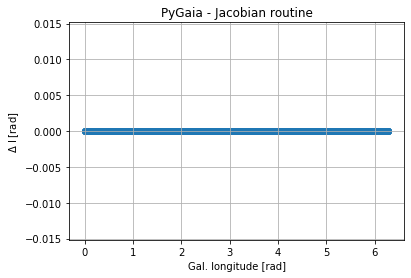

In [23]:
plt.scatter(comparison.l_pygaia,comparison.l_pygaia-comparison.l_jacob)
plt.grid()
#plt.ylim(-1e-3,1e-3);
plt.xlabel('Gal. longitude [rad]')
plt.ylabel(r'$\Delta$ l [rad]')
plt.title('PyGaia - Jacobian routine');